In [54]:
from __future__ import print_function, division

In [55]:
# import libraries
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import scale
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, RANSACRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from mlens.ensemble import SuperLearner
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.utils import resample, shuffle

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


### Data Inputs

In [56]:
# update your data path
DATA_PATH = "/home/aunagar/Personal/Study/Sem1/Advanced ML/projects/task1/Task1/"

In [57]:
# import data
train_X = pd.read_csv(DATA_PATH + "X_train.csv")
train_Y = pd.read_csv(DATA_PATH + "y_train.csv")
test_X = pd.read_csv(DATA_PATH + "X_test.csv")
sample_submission = pd.read_csv(DATA_PATH + "sample.csv")

In [58]:
# split data
train_ids = train_X.iloc[:, 0]
train_features = train_X.iloc[:, 1:]
test_ids = test_X.iloc[:, 0]
test_features = test_X.iloc[:, 1:]

### Preprocessing

In [60]:
def missing_value_imputation(train, test):
    train = train.fillna(train.median())
    
    test = test.fillna(train.median())
    
    return train, test

def outlier_treatment(train, test):
    
    train_mean, train_std = train.mean(), train.std()
    
    train[train > train_mean + 2*train_std] = np.nan
    train[train < train_mean - 2*train_std] = np.nan
    
    test[test > train_mean + 2*train_std] = np.nan
    test[test < train_mean - 2*train_std] = np.nan
    
    train = train.fillna(train_mean)
    test = test.fillna(train_mean)
    
    return train, test

def normalize(train, test):
    train_mean, train_std = train.mean(), train.std()

    train = (train - train_mean)/train_std
    # test 
    test = (test - train_mean)/train_std
    
    return train, test

def remove_corr_features(train, test, threshold = 0.8):
    
    # Create correlation matrix
    corr_matrix = train.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # train
    train = train.drop(columns = to_drop)
    # test
    test = test.drop(columns = to_drop)
    
    return train, test
        
def preprocess(train, test):
    
    # impute missing values
    train, test = missing_value_imputation(train, test)
    
    # remove columns with 0 variance
    train_mean, train_std = train.mean(), train.std()
    train = train.iloc[:, np.where(train_std > 0.0)[0]]
    test = test.iloc[:, np.where(train_std > 0.0)[0]]
    
    # remove outliers
    train, test = outlier_treatment(train, test)
    
    # normalize
    train, test = normalize(train, test)
    
    # remove correlated features
    train, test = remove_corr_features(train, test)
    
    return train, test

In [61]:
train_features, test_features = preprocess(train_features, test_features)

### Exploration

### Feature selection

In [62]:
###### linear model
lr = ElasticNet(alpha = 0.2, l1_ratio = 1.)
validation_score = cross_val_score(lr, train_features, train_Y.iloc[:, 1:], cv = 5, scoring = 'r2')
print(validation_score.mean())

# train model on whole train data
lr.fit(X = train_features, y = train_Y.iloc[:, 1])

0.4868994898925784


ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
# finding to which features to remove
non_zero_weights = np.where(lr.coef_ != 0.)[0]

# removing these features from training data
train_features = train_features.iloc[:, non_zero_weights]
test_features = test_features.iloc[:, non_zero_weights]

In [64]:
print("training size is ", train_features.shape, " and test size is ", test_features.shape)

training size is  (1212, 189)  and test size is  (776, 189)


### Model selection

In [65]:
train_x, test_x, train_y, test_y = train_test_split(train_features, train_Y.iloc[:, 1], test_size = 0.33,
                                                    random_state = 42)

In [66]:
def R2(ypred, ytrue):
    y_avg = np.mean(ytrue)
    SS_tot = np.sum((ytrue - y_avg)**2)
    SS_res = np.sum((ytrue - ypred)**2)
    r2 = 1 - (SS_res/SS_tot)
    return r2

def cross_validate(model, x, y, folds=10, repeats=5):
    '''
    Function to do the cross validation - using stacked Out of Bag method instead of averaging across folds.
    model = algorithm to validate. Must be scikit learn or scikit-learn like API (Example xgboost XGBRegressor)
    x = training data, numpy array
    y = training labels, numpy array
    folds = K, the number of folds to divide the data into
    repeats = Number of times to repeat validation process for more confidence
    '''
    ypred = np.zeros((len(y),repeats))
    score = np.zeros(repeats)
    x = np.array(x)
    for r in range(repeats):
        i=0
        print('Cross Validating - Run', str(r + 1), 'out of', str(repeats))
        x,y = shuffle(x,y,random_state=r) #shuffle data before each repeat
        kf = KFold(n_splits=folds,random_state=i+1000) #random split, different each time
        for train_ind,test_ind in kf.split(x):
            print('Fold', i+1, 'out of',folds)
            xtrain,ytrain = x[train_ind,:],y[train_ind]
            xtest,ytest = x[test_ind,:],y[test_ind]
            model.fit(xtrain, ytrain)
            ypred[test_ind,r]=model.predict(xtest)
            i+=1
        score[r] = R2(ypred[:,r],y)
    print('\nOverall R2:',str(score))
    print('Mean:',str(np.mean(score)))
    print('Deviation:',str(np.std(score)))
    return score.mean()


In [68]:
#### training more complex model on this cleared date

###### linear model
alpha = np.arange(0.1, 2, 0.2)
l1_ratio = np.arange(0.1, 1, 0.2)
results = pd.DataFrame(columns=['alpha', 'l1_ratio', 'cv_score'])
for a in alpha:
    for l1 in l1_ratio:
        lr = ElasticNet(alpha = a, l1_ratio=l1)
        validation_score = cross_validate(lr, train_x.values, train_y.values)
        results = results.append({'alpha':a, 'l1_ratio':l1, 'cv_score':validation_score.mean()}, ignore_index = True)

best_parameters = results.iloc[np.argmax(results.cv_score.values),:]
print(best_parameters['cv_score'])

# linear Elastic NEt
lr = ElasticNet(alpha = best_parameters['alpha'], l1_ratio = best_parameters['l1_ratio'])

Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out

Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10

Overall R2: [0.55997117 0.5555022  0.56224903 0.55327324 0.55349065]
Mean: 0.5568972556012863
Deviation: 0.0035993063522514004


Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10

Overall R2: [0.49019356 0.49120283 0.49430609 0.49267109 0.48814024]
Mean: 0.4913027614927823
Deviation: 0.00210400228892061
Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fol

Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10

Overall R2: [0.51718698 0.51687887 0.5217585  0.51832412 0.51646785]
Mean: 0.518123262229032
Deviation: 0.0019194177218596177
Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fo

Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10

Overall R2: [0.46520666 0.46830597 0.46881258 0.46634078 0.4640079 ]
Mean: 0.46653477708692614
Deviation: 0.0018172587532541702
Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10


Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10

Overall R2: [0.53332997 0.53290723 0.53426747 0.53225584 0.53228379]
Mean: 0.5330088615728851
Deviation: 0.0007470354364967322
Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
F


Overall R2: [0.45218851 0.45485409 0.45599438 0.45378228 0.45200635]
Mean: 0.45376512258131535
Deviation: 0.0015319731773307341
Cross Validating - Run 1 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 2 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 3 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 4 out of 5
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Fold 10 out of 10
Cross Validating - Run 5 out of 5
Fold 1 out of 10


In [70]:
lr.fit(train_x, train_y)
lr_pred = lr.predict(test_x)

In [71]:
lr_score = lr.score(test_x, test_y)

In [72]:
print(lr_score)

0.5897784675220828


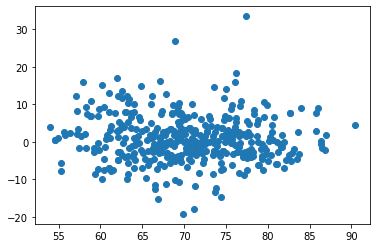

In [20]:
plt.scatter(lr_pred, lr_pred-test_y)
plt.show()

### Predictions

In [21]:
best_model = lr

In [73]:
best_model.fit(train_features, train_Y.iloc[:, 1])

ElasticNet(alpha=0.30000000000000004, copy_X=True, fit_intercept=True,
           l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [74]:
predicted = best_model.predict(test_features)

In [75]:
predicted_Round = np.round(predicted)

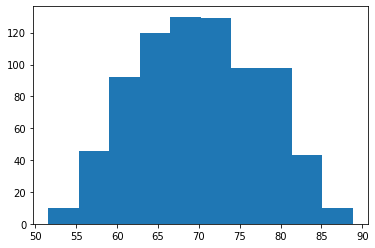

In [76]:
plt.hist(predicted)
plt.show()

In [77]:
#predicted = best_model.predict(test_features)
sample_submission['y'] = predicted

In [78]:
sample_submission.to_csv("submissions/Ajay_16th_sub.csv", index = False)